# Finding discords of any length in a time series

This tutorial explains the MERLIN algorithm proposed in [MERLIN](https://www.cs.ucr.edu/~eamonn/MERLIN_Long_version_for_website.pdf). 

You can find the support webpage here: [MERLIN: SUPPORT](https://sites.google.com/view/merlin-find-anomalies).

The algorithm provides the discords of arbitrary length in time series.

## import libraries

In [2]:
%matplotlib inline

import pandas as pd
import stumpy
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('stumpy.mplstyle')

# import toy data set: noisy sine wave

In [3]:
from scipy.io import loadmat

# data set is available at: 
# https://drive.google.com/file/d/1cDkZVKYse_E0_fGZqTRQZrrMBRFrR2Mv/view

data = loadmat("MERLIN_data\\NoisySine.mat") 
ts = data['T'].reshape(-1,)

## Visualizing data

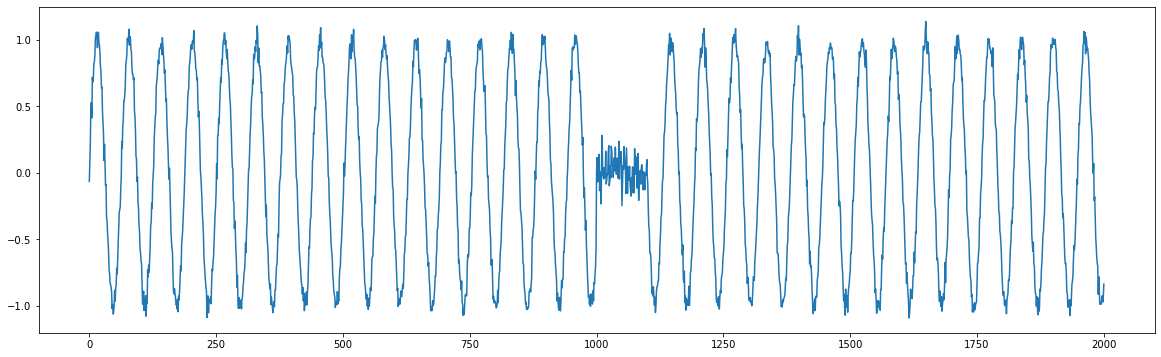

In [4]:
plt.plot(ts)
plt.show()

As depicted in the figure above, there is an anomaly in the sequence

## implemeting MERLIN algorithm

### part I: DRAG algorithm 

DRAG algorithm is a name used by the authors to refer to the algorithm proposed in [](). The DRAG aglorithm tries to find a set of discords for a user-defined r (range of discord: the threshold. A subsequence is discord if its distance to its NN is not less than r.

In [5]:
def candidate_selection_algorithm(
    T_A, 
    m, 
    r
):
    """
    For a time series T_A, the algorithm finds a set of discords whose distance with their NN is more than r. 
    
    Parameters
    ---------
    T_A: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    
    output
    --------
    C: set
        a set of discords
    
    """
    z_normalize = True
    
    #create empty set
    C = set()
    
    #scan all subsequences
    for i in range(0,len(T_A)-m):
        is_candidate = True
        T_i = T_A[i:(i+m)]
        T_i = stumpy.core.z_norm(T_i)
        
        for j in C:
            if abs(i-j)>=m: #non-trival match test
                T_j = T_A[j:(j+m)]
                T_j = stumpy.core.z_norm(T_j)
                
                dist = np.linalg.norm(T_i-T_j)
                if dist < r:
                    is_candidate = False
                    break
        
        if is_candidate:
            C.add(i)
        else:
            C.remove(j)

            
    return C

In [6]:
T = ts[:]
m = 512 #one day as the length of subsequence
r = 10.27

C = candidate_selection_algorithm(T, m, r)
print('set C is: \n', C)

set C is: 
 {549, 550, 551, 552, 555, 556, 557, 558, 559, 560, 561, 562, 563, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 710, 711, 712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724, 725, 726, 728, 731, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 796, 797, 798, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 81

In [7]:
def discords_refinement_algorithm(
    T_A, 
    m, 
    r, 
    C
):
    """
    For a time series T_A, the algorithm refines a set of discords by removing the false positives,
    i.e. the subsequences whose distance from their NN is more than r. 
    
    Parameters
    ---------
    T_A: ndarray
        the time series for which we try to find the discords
    
    m: int
        the length of the subsequence to consider in discovering the discords
    
    r: float
        the maximum distance allowed for non-discord subsquence to its NN subsequence 
        (threshold for discords' distance)
    
    C: set
        the set of indices of initially-discovered discored
    
    
    output
    --------
    D: ndarray
        a 2d array where the first axis corresponds to the discords, and the second axis contains information for each discord
        
    
    ind_to_remove: ndarray
        an array that contains the indices that need to be removed from D.
    """
    C_list = list(C)
    
    D=np.empty(shape=(len(C_list),3)) #[discord index, discord NN index, NN dist]
    D[:,0] = C_list
    D[:,1] = -1
    D[:,2] = float('inf')
    
    _to_be_removed_idx = []
    
    
    for i in range(0, len(T_A)-m):
        if len(C_list)==0:
            print('The set C is empty. No discord discovered!')
            break
        
        is_discord = True
        T_i = T_A[i:(i+m)]
        T_i = stumpy.core.z_norm(T_i)
        
        for j_idx, j in enumerate(C_list):
            if j_idx not in _to_be_removed_idx:
                if abs(i-j)>=m:
                    T_j = T_A[j:(j+m)]
                    T_j = stumpy.core.z_norm(T_j)

                    dist = np.linalg.norm(T_i-T_j)
                    if dist<r:
                        _to_be_removed_idx.append(j_idx)
                    else:
                        D[j_idx,1] = i
                        D[j_idx,2] = min(D[j_idx,2],dist)

        
    return np.delete(D, _to_be_removed_idx, axis=0)

In [8]:
D = discords_refinement_algorithm(T, m, r, C)

df = pd.DataFrame(data = D, 
                  columns = ['Discord index', 'Discord NN index', 'NN distance'])

df_sorted = df.sort_values(by ='NN distance', ascending=False, ignore_index=True)
df_sorted

,Discord index,Discord NN index,NN distance
0,938.0,1488.0,10.439015
1,939.0,1488.0,10.437721
2,937.0,1488.0,10.436094
3,844.0,1488.0,10.433220
4,940.0,1488.0,10.433127
...,...,...,...
303,826.0,1488.0,10.271512
304,632.0,1488.0,10.271437
305,738.0,1488.0,10.271434
306,895.0,1488.0,10.270160


### PLOT the Top Discord

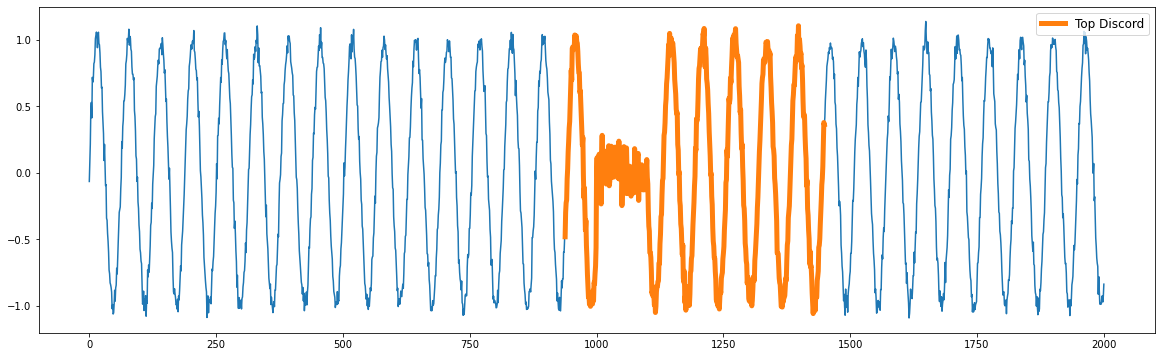

In [15]:
Top_Discord = df_sorted.iloc[0,:]
Top_Discord_idx = int(Top_Discord[0])

plt.plot(ts)
plt.plot(np.arange(Top_Discord_idx,Top_Discord_idx+m),ts[Top_Discord_idx:Top_Discord_idx+m], lw=5, label='Top Discord')
plt.legend(fontsize=12)
plt.show()